Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 125s 745ms/step - loss: 0.3882 - accuracy: 0.8503 - val_loss: 9.7301 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 110s 670ms/step - loss: 0.2285 - accuracy: 0.9049 - val_loss: 5.7786 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 109s 666ms/step - loss: 0.2165 - accuracy: 0.9128 - val_loss: 10.2345 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 109s 665ms/step - loss: 0.1863 - accuracy: 0.9227 - val_loss: 4.0600 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 112s 685ms/step - loss: 0.1742 - accuracy: 0.9352 - val_loss: 1.8019 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 115s 702ms/step - loss: 0.1677 - accuracy: 0.9346 - val_loss: 4.6095 - val_accuracy: 0.5000


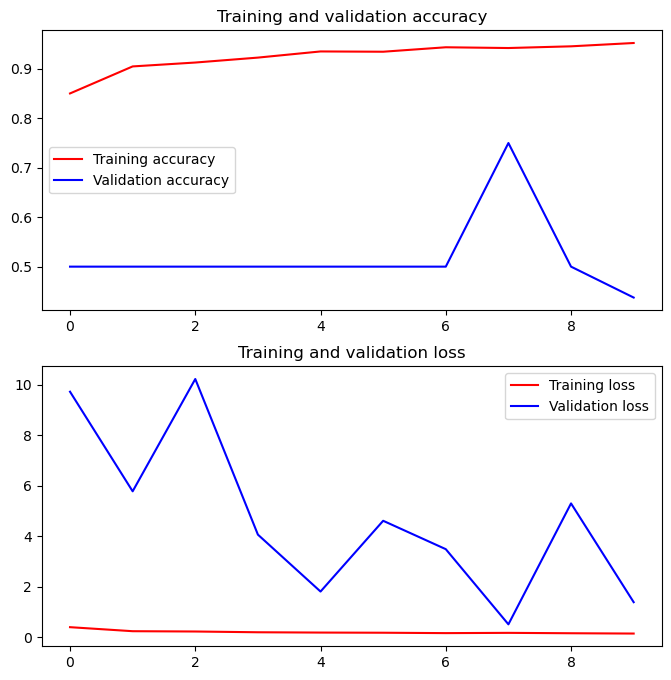

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

train_dir = 'train'
validation_dir = 'val'
test_dir = 'test'

# Set up the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create the data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

models = [VGG16]

# Function to build and compile model
def build_model(base_model):
    base_model.trainable = False  # Freeze the base model for feature extraction
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
    model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
    model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train models
for model_func in models:
    base_model = model_func(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = build_model(base_model)
    
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

# Plot the training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)


END